In [1]:
# ! pip show tensorflow
# ! pip show tensorflow-gpu
# !pip show keras

In [2]:
!pwd

/masvol/heartsmart/unet_model


In [3]:
#import cv2 
import re, sys
import fnmatch, shutil, subprocess
from IPython.utils import io
import glob

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import numpy as np
from keras.models import *
from keras.layers import Input, concatenate, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import binary_crossentropy
import keras.backend as K

#Fix the random seeds for numpy (this is for Keras) and for tensorflow backend to reduce the run-to-run variance
from numpy.random import seed
seed(100)
from tensorflow import set_random_seed
set_random_seed(200)

import matplotlib.pyplot as plt
%matplotlib inline

print("\nSuccessfully imported packages!!!\n")


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



Successfully imported packages!!!



In [6]:
# config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
# #config.gpu_options.per_process_gpu_memory_fraction = 0.4
# #config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# #sess.run(yourcommand)

In [8]:
#Settings
TRAIN_TEST_SPLIT_RATIO = 0.1  # train/test split ratio for Sunnybrook and ACDC data

BASE_DIR = "/opt/output/"
SB_SOURCE = "sunnybrook"
TRAIN_IMG_DIR = BASE_DIR + SB_SOURCE + "/norm/1/3/images/"
TRAIN_LBL_DIR = BASE_DIR + SB_SOURCE + "/norm/1/3/labels/"

TEST_IMG_DIR = BASE_DIR + SB_SOURCE + "/norm/1/3/images/"
PRED_RESULT_DIR = BASE_DIR + SB_SOURCE + "/norm/1/3/images/"

UNET_TRAIN_DIR = BASE_DIR + SB_SOURCE + "/unet_model/data/"
UNET_MODEL_DIR = BASE_DIR + SB_SOURCE + "/unet_model/models/"


UNET_TRAIN_DIR = "/masvol/heartsmart/unet_model/data/"
UNET_MODEL_DIR = "/masvol/heartsmart/unet_model/models/"

# UNET_TRAIN_DIR = "/masvol/heartsmart/unet_model/data/"
# UNET_MODEL_DIR = "/masvol/heartsmart/unet_model/models/"

# UNET_TRAIN_DIR = "/opt/heartsmart/unet_model/data/"
# UNET_MODEL_DIR = "/opt/heartsmart/unet_model/models/"

DSB_SOURCE = "dsb"
DSB_TRAIN_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/train/"
DSB_VAL_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/validate/"
DSB_TEST_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/test/"



## Methods to extract sunnybrook contour files and corresponding image files 
#### And save them as 4d numpy arrays

Mapping ground truth contours to images...
Number of examples: 805
Shuffle data
/opt/output/sunnybrook/norm/1/3/labels/SC-HF-NI-3/IM-0379-0100.dcm.label.npy /opt/output/sunnybrook/norm/1/3/labels/SC-N-10/IM-0851-0087.dcm.label.npy
Number of examples after cleanup: 805
Contour 0 : SC-HF-NI-3 379 100
Contour -1 : SC-N-10 851 87
Done mapping ground truth contours to images
Split train_set:725, test_set:80
Extracting Training Images and Labels
Processing 725 images and labels...
(256, 256) /opt/output/sunnybrook/norm/1/3/images/


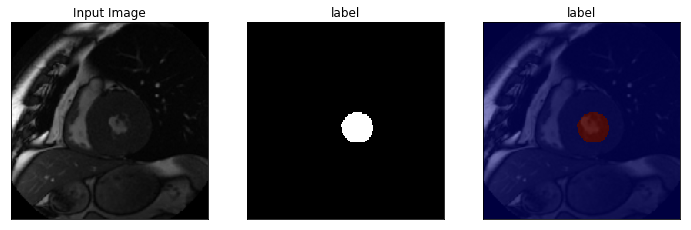

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


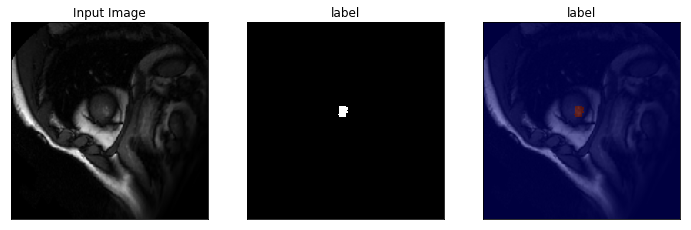

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


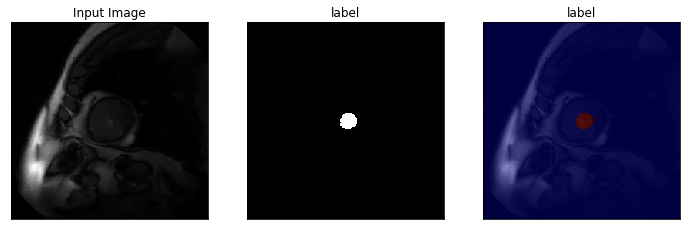

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


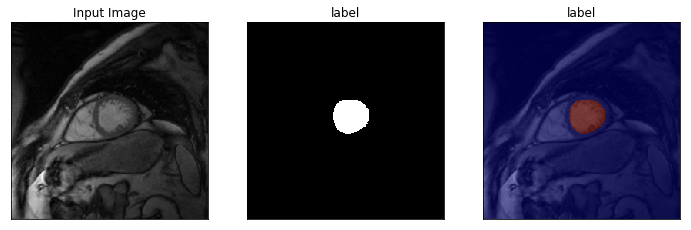

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


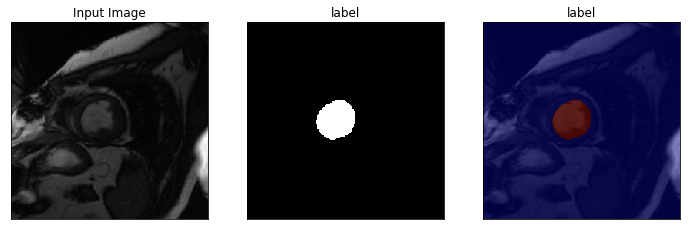

Processed 725 images and labels...
Extracting Test Images and Labels
Processing 80 images and labels...
(256, 256) /opt/output/sunnybrook/norm/1/3/images/


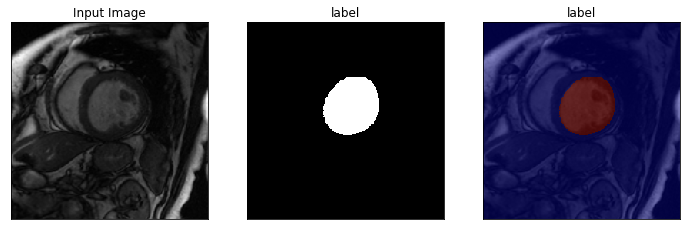

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


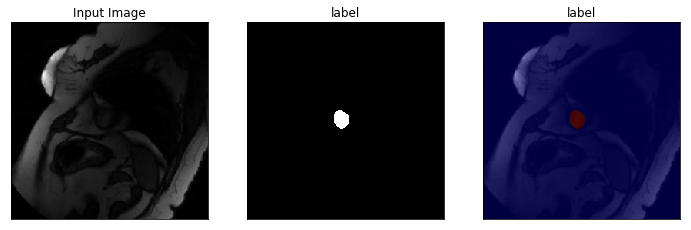

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


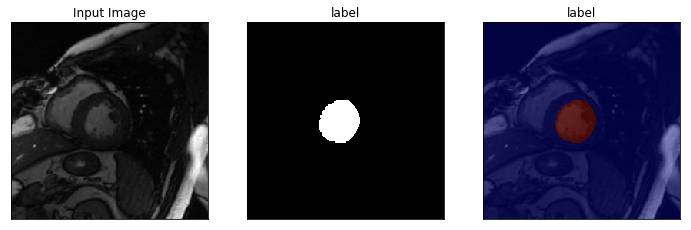

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


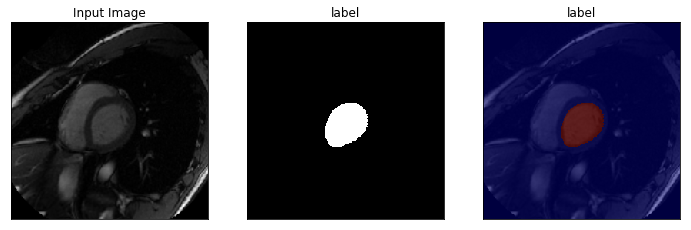

(256, 256) /opt/output/sunnybrook/norm/1/3/images/


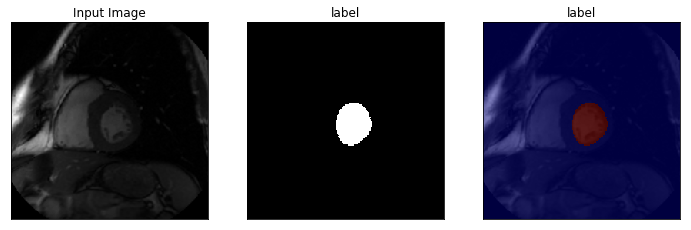

Processed 80 images and labels...
Extracted Images train_set:725, test_set:80
Mapping ground truth contours to images...
Number of examples: 805
Shuffle data
/opt/output/sunnybrook/norm/1/3/labels/SC-HF-NI-12/IM-0286-0240.dcm.label.npy /opt/output/sunnybrook/norm/1/3/labels/SC-HF-NI-34/IM-0446-0179.dcm.label.npy
Number of examples after cleanup: 805
Contour 0 : SC-HF-NI-12 286 240
Contour -1 : SC-HF-NI-34 446 179
Done mapping ground truth contours to images
Split train_set:725, test_set:80
Extracting Training Images and Labels
Processing 725 images and labels...
(176, 176) /opt/output/sunnybrook/norm/1/3/images/


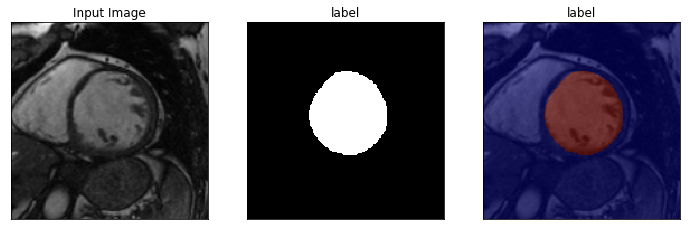

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


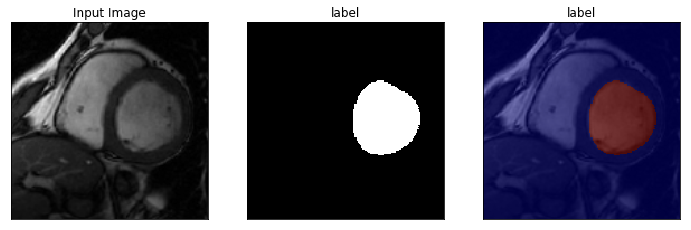

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


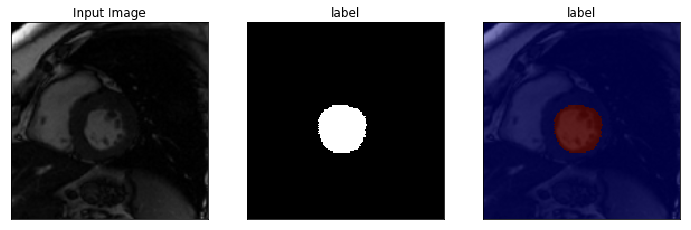

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


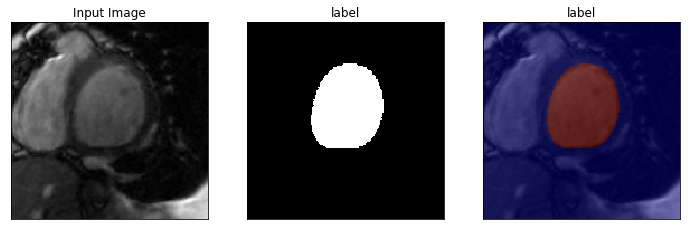

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


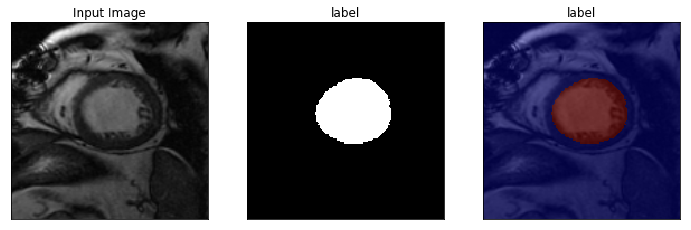

Processed 725 images and labels...
Extracting Test Images and Labels
Processing 80 images and labels...
(176, 176) /opt/output/sunnybrook/norm/1/3/images/


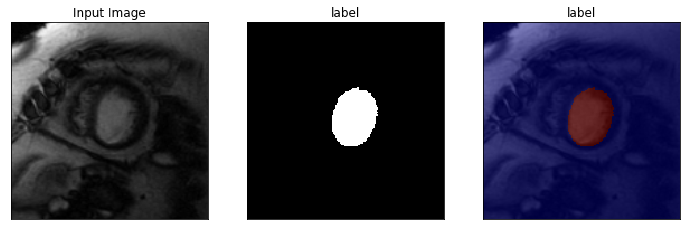

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


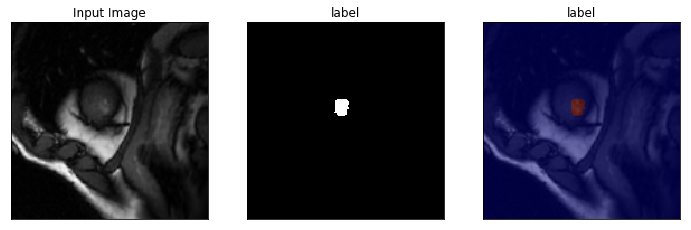

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


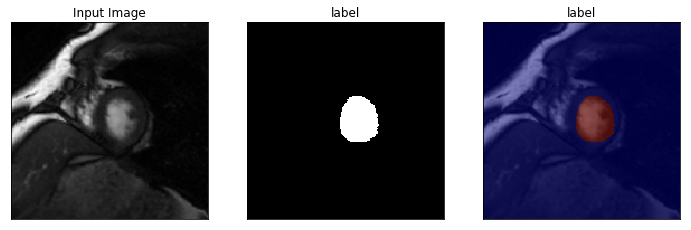

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


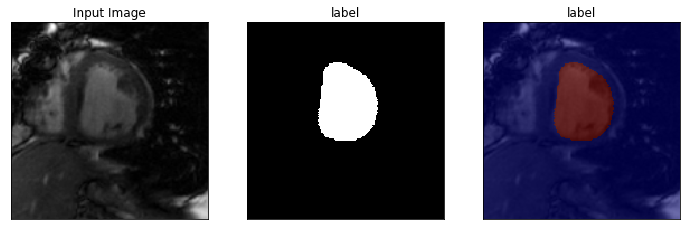

(176, 176) /opt/output/sunnybrook/norm/1/3/images/


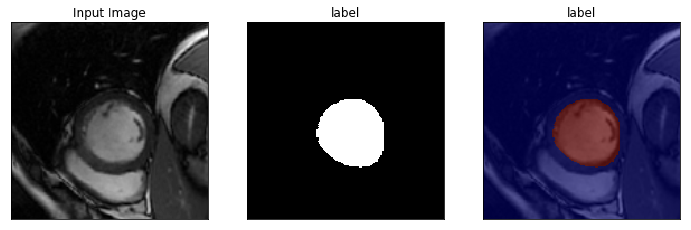

Processed 80 images and labels...
Extracted Images train_set:725, test_set:80


NameError: name 'SOURCE' is not defined

In [9]:
##################################
#
# Methods to extract sunnybrook contour files and corresponding image files 
#
###################################

SAX_SERIES_ALL = {
    'SC-HF-I-1': '0004',
    'SC-HF-I-2': '0106',
    'SC-HF-I-4': '0116',
    'SC-HF-I-5': '0156',
    'SC-HF-I-6': '0180',
    'SC-HF-I-7': '0209',
    'SC-HF-I-8': '0226',
    'SC-HF-I-9': '0241',
    'SC-HF-I-10': '0024',
    'SC-HF-I-11': '0043',
    'SC-HF-I-12': '0062',
    'SC-HF-I-40': '0134',
    'SC-HF-NI-3': '0379',
    'SC-HF-NI-4': '0501',
    'SC-HF-NI-7': '0523',
    'SC-HF-NI-12': '0286',
    'SC-HF-NI-11': '0270',
    'SC-HF-NI-13': '0304',
    'SC-HF-NI-14': '0331',
    'SC-HF-NI-15': '0359',
    'SC-HF-NI-31': '0401',
    'SC-HF-NI-33':'0424',
    'SC-HF-NI-34': '0446',
    'SC-HF-NI-36': '0474',
    'SC-HYP-1': '0550',
    'SC-HYP-3': '0650',
    'SC-HYP-6': '0767',
    'SC-HYP-7': '0007',
    'SC-HYP-8': '0796',
    'SC-HYP-9': '0003',
    'SC-HYP-10': '0579',
    'SC-HYP-11': '0601',
    'SC-HYP-12': '0629',
    'SC-HYP-37': '0702',
    'SC-HYP-38': '0734',
    'SC-HYP-40': '0755',
    'SC-N-2': '0898',
    'SC-N-3': '0915',
    'SC-N-5': '0963',
    'SC-N-6': '0981',
    'SC-N-7': '1009',
    'SC-N-9': '1031',
    'SC-N-10': '0851',
    'SC-N-11': '0878',
    'SC-N-40': '0944',
}



def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path                
        match = re.search(r"/([^/]*)/IM-(\d{4})-(\d{4}).dcm.label.npy", ctr_path)
        self.case = shrink_case(match.group(1))
        self.record = int(match.group(2))
        self.img_no = int(match.group(3))
    
    def __str__(self):
        return "<Contour for case %s, record %d image %d>" % (self.case, self.record, self.img_no)
    
    __repr__ = __str__

def crop_center(img,cropx,cropy):
    x,y = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[startx:startx+cropx, starty:starty+cropy]

def pad_image(img, img_size):
    #print ("input shape : ", img.shape)
    pad_x=0
    pad_y=0
    x,y = img.shape
    if (x<img_size):
        pad_x = img_size - x
    if (y<img_size):
        pad_y = img_size - y
    process_img = np.pad(img, pad_width=((pad_x//2, ((pad_x//2) + (pad_x % 2))), (pad_y//2, ((pad_y//2) + (pad_y % 2)))), mode = 'constant', constant_values = 0)
    #print ("output shape : ", process_img.shape)
    return process_img


def load_contour(contour, img_path, crop_size):
    # file = IM-0851-0127.dcm.npy
    filename = "IM-%s-%04d.dcm.npy" % (SAX_SERIES_ALL[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    img = np.load(full_path)
    label = np.load(contour.ctr_path)
    height, width = img.shape
    height_l, width_l = label.shape
    if height != crop_size or width !=crop_size:
        #print ("img: ", contour.img_no, height, width)
        #print ("lbl: ", height_l, width_l)
        img = crop_center(img,crop_size,crop_size)
        label = crop_center(label,crop_size,crop_size)
    return img, label

   
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-*dcm.label.npy')]
    print("Number of examples: {:d}".format(len(contours)))
    print("Shuffle data")
    np.random.shuffle(contours)
    print (contours[0], contours[-1])
    print("Number of examples after cleanup: {:d}".format(len(contours)))
    extracted = list(map(Contour, contours))
    print ("Contour 0 :", extracted[0].case, extracted[0].record, extracted[0].img_no)
    print ("Contour -1 :", extracted[-1].case, extracted[-1].record, extracted[-1].img_no) 
    return extracted

def get_contours_and_images(contours, img_path, crop_size):

    num_contours = len(contours)
    print("Processing {:d} images and labels...".format(num_contours))        
    imgs, labels = [], []
        
    for idx,ctr in enumerate(contours):
        img, label = load_contour(ctr, img_path, crop_size)
        imgs.append(img)
        labels.append(label)

        if idx % (num_contours//5) == 0: # print up to 5 images
            print (img.shape, img_path)
            f, axs = plt.subplots(1,3,figsize=(12,12))
            plt.subplot(131),plt.imshow(img, cmap = 'gray')
            plt.title('Input Image'), plt.xticks([]), plt.yticks([])
            plt.subplot(132),plt.imshow(label, cmap = 'gray')
            plt.title('label'), plt.xticks([]), plt.yticks([])
            plt.subplot(133),plt.imshow(img, cmap = 'gray')
            plt.imshow(label, 'jet', interpolation='none', alpha=0.5)
            plt.title('label'), plt.xticks([]), plt.yticks([])
            plt.show()

    print("Processed {:d} images and labels...".format(len(imgs))) 
    return imgs, labels

def save_training_data(imgs, lbls, save_file_path, file_prefix, image_size):
    rows = image_size
    cols = image_size
    i = 0
    print('-'*30)
    print("Creating training data..input size : ",len(imgs))
    print('-'*30)
    print("Converting data to np array")
    
    imgdatas = np.ndarray((len(imgs),rows,cols,1), dtype=np.int)
    
    imglabels = np.ndarray((len(imgs),rows,cols,1), dtype=np.uint8)
    
    for idx in range(len(imgs)):
        img = imgs[idx]
        label = lbls[idx]
        img = img_to_array(img)
        label = img_to_array(label)
        
        try:
            imgdatas[i] = img
            imglabels[i] = label
            i += 1
        except Exception as e:
            print (e)
            continue
        
    imgfile = save_file_path + file_prefix +"_images.npy"
    print (imgfile)
    lblfile = save_file_path + file_prefix +"_labels.npy"
    np.save(imgfile, imgdatas)
    np.save(lblfile, imglabels)

    print ("Shape of data & label np arrays : ", imgdatas.shape, imglabels.shape)
    print (imgdatas.max(), imgdatas.min(), imglabels.max(), imglabels.min())
    print('Saved data as: ', imgfile, lblfile )


def extract_sunnybrook_training_data(crop_size=256): 
    SPLIT_RATIO = TRAIN_TEST_SPLIT_RATIO  # train/test split ratio
    print("Mapping ground truth contours to images...")
    ctrs = get_all_contours(TRAIN_LBL_DIR)
    print("Done mapping ground truth contours to images")
    test_ctrs = ctrs[0:int(SPLIT_RATIO*len(ctrs))]
    train_ctrs = ctrs[int(SPLIT_RATIO*len(ctrs)):]
    print("Split train_set:%d, test_set:%d"%(len(train_ctrs), len(test_ctrs)))
    print ("Extracting Training Images and Labels")
    train_imgs, train_labels = get_contours_and_images(train_ctrs, TRAIN_IMG_DIR, crop_size)
    print ("Extracting Test Images and Labels")
    test_imgs, test_labels = get_contours_and_images(test_ctrs, TRAIN_IMG_DIR, crop_size)
    print("Extracted Images train_set:%d, test_set:%d"%(len(train_imgs), len(test_imgs)))
    return train_imgs, train_labels, test_imgs, test_labels 

if __name__ == "__main__":
    ##Get sunnybrook images and labels with crop from center to get 256x256 images
    train_imgs, train_labels, test_imgs, test_labels = extract_sunnybrook_training_data(crop_size=256)

    ##Get sunnybrook images and labels with crop from center to get 180x180 images

    train_imgs2, train_labels2, test_imgs2, test_labels2 = extract_sunnybrook_training_data(crop_size=176)

    ### Create 256x256 size train/test data in 4d tensor shape and save them
    save_location = UNET_TRAIN_DIR
    tr_file_prefix = SB_SOURCE + "_256_train"
    tst_file_prefix = SB_SOURCE + "_256_test"
    save_training_data(train_imgs, train_labels, save_location, tr_file_prefix, image_size = 256)
    save_training_data(test_imgs, test_labels, save_location, tst_file_prefix, image_size = 256)

    ### Create 180x180 size train/test data in 4d tensor shape and save them
    tr_file_prefix = SB_SOURCE + "_176_train"
    tst_file_prefix = SB_SOURCE + "_176_test"

    save_training_data(train_imgs2, train_labels2, save_location, tr_file_prefix, image_size = 176)
    save_training_data(test_imgs2, test_labels2, save_location, tst_file_prefix, image_size = 176)
    


## Methods to load 4d np array for images from ./data directory, perform pixel normalization

In [10]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def load_images_and_labels(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)
    
    im = np.load(imgfile)
    lb = np.load(labelfile)
    images = im.astype('float32')
    labels = lb.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images2, labels


def load_images(imgfile):
    print('-'*30)
    print('load np arrays of images ...')
    print('-'*30)
    print ("Loading files : ", imgfile)
    
    im = np.load(imgfile)
    images = im.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    return images2

In [11]:
sb_test_data = {}
sb_test_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_test_images.npy"
sb_test_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_test_labels.npy"
sb_test_img, sb_test_lbl = load_images_and_labels(sb_test_data)

------------------------------
load np arrays of images and labels...
------------------------------
Loading files :  /masvol/heartsmart/unet_model/data/sunnybrook_256_test_images.npy /masvol/heartsmart/unet_model/data/sunnybrook_256_test_labels.npy
shape, max, min, mean of original image set: (80, 256, 256, 1) 3071.0 0.0 114.81773
shape, max, min, mean after normalization  : (80, 256, 256, 1) 1.0 0.0 0.12337347
shape, max, min, mean of labels : (80, 256, 256, 1) 1.0 0.0 0.030335044
